In [3]:
%matplotlib inline


# Complex and semantic figure composition

<div class="alert alert-danger"><h4>Warning</h4><p>This tutorial documents experimental / provisional API.
   We are releasing this in v3.3 to get user feedback.  We may
   make breaking changes in future versions with no warning.</p></div>


Laying out Axes in a Figure in a non uniform grid can be both tedious
and verbose.  For dense, even grids we have `.Figure.subplots` but for
more complex layouts, such as Axes that span multiple columns / rows
of the layout or leave some areas of the Figure blank, you can use
`.gridspec.GridSpec` (see :doc:`/tutorials/intermediate/arranging_axes`) or
manually place your axes.  `.Figure.subplot_mosaic` aims to provide an
interface to visually lay out your axes (as either ASCII art or nested
lists) to streamline this process.

This interface naturally supports naming your axes.
`.Figure.subplot_mosaic` returns a dictionary keyed on the
labels used to lay out the Figure.  By returning data structures with
names, it is easier to write plotting code that is independent of the
Figure layout.


This is inspired by a [proposed MEP](https://github.com/matplotlib/matplotlib/pull/4384)_ and the
[patchwork](https://github.com/thomasp85/patchwork)_ library for R.
While we do not implement the operator overloading style, we do
provide a Pythonic API for specifying (nested) Axes layouts.


In [4]:
import matplotlib.pyplot as plt
import numpy as np


# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

If we want a 2x2 grid we can use `.Figure.subplots` which returns a 2D array
of `.axes.Axes` which we can index into to do our plotting.



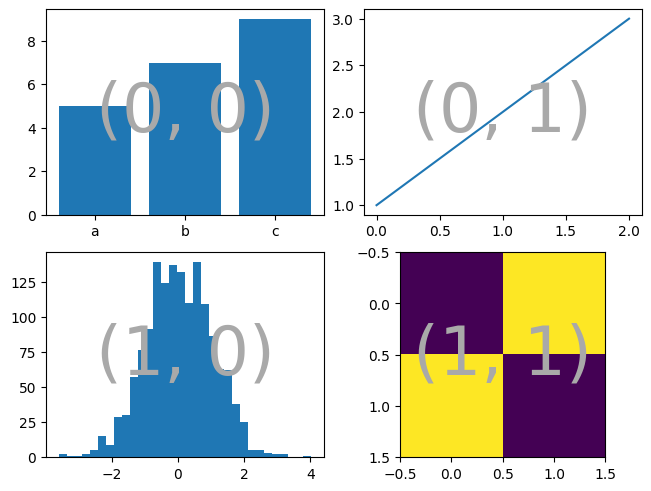

In [5]:
np.random.seed(19680801)
hist_data = np.random.randn(1_500)


fig = plt.figure(constrained_layout=True)
ax_array = fig.subplots(2, 2, squeeze=False)

ax_array[0, 0].bar(["a", "b", "c"], [5, 7, 9])
ax_array[0, 1].plot([1, 2, 3])
ax_array[1, 0].hist(hist_data, bins="auto")
ax_array[1, 1].imshow([[1, 2], [2, 1]])

identify_axes(
    {(j, k): a for j, r in enumerate(ax_array) for k, a in enumerate(r)},
)

Using `.Figure.subplot_mosaic` we can produce the same mosaic but give the
axes semantic names



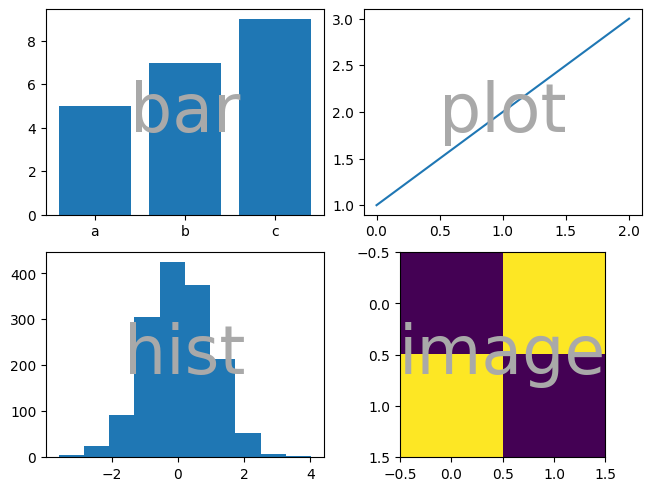

In [6]:
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(
    [
        ["bar", "plot"],
        ["hist", "image"],
    ],
)
ax_dict["bar"].bar(["a", "b", "c"], [5, 7, 9])
ax_dict["plot"].plot([1, 2, 3])
ax_dict["hist"].hist(hist_data)
ax_dict["image"].imshow([[1, 2], [2, 1]])
identify_axes(ax_dict)

A key difference between `.Figure.subplots` and
`.Figure.subplot_mosaic` is the return value. While the former
returns an array for index access, the latter returns a dictionary
mapping the labels to the `.axes.Axes` instances created



In [7]:
print(ax_dict)

{'bar': <Axes: label='bar'>, 'plot': <Axes: label='plot'>, 'hist': <Axes: label='hist'>, 'image': <Axes: label='image'>}


## String short-hand

By restricting our axes labels to single characters we can
"draw" the Axes we want as "ASCII art".  The following



In [8]:
mosaic = """
    AB
    CD
    """

will give us 4 Axes laid out in a 2x2 grid and generates the same
figure mosaic as above (but now labeled with ``{"A", "B", "C",
"D"}`` rather than ``{"bar", "plot", "hist", "image"}``).



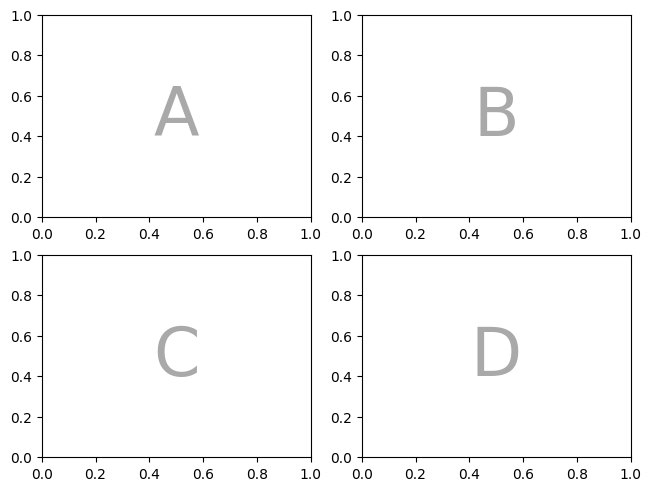

In [9]:
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
identify_axes(ax_dict)

Alternatively, you can use the more compact string notation



In [10]:
mosaic = "AB;CD"

will give you the same composition, where the ``";"`` is used
as the row separator instead of newline.



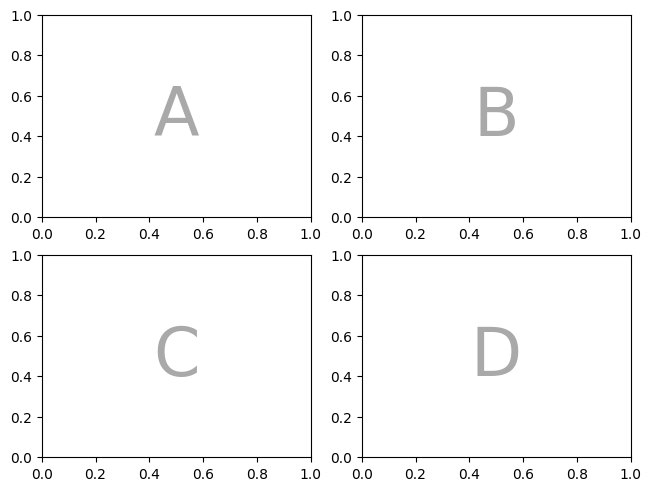

In [11]:
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
identify_axes(ax_dict)

## Axes spanning multiple rows/columns

Something we can do with `.Figure.subplot_mosaic` that you can not
do with `.Figure.subplots` is specify that an Axes should span
several rows or columns.



If we want to re-arrange our four Axes to have ``"C"`` be a horizontal
span on the bottom and ``"D"`` be a vertical span on the right we would do



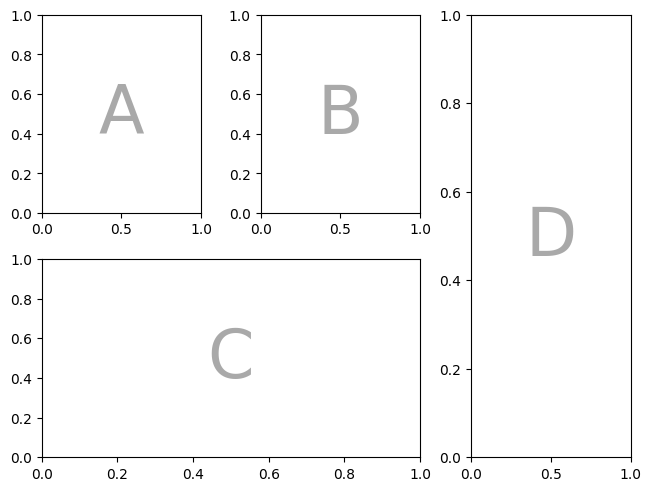

In [12]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    ABD
    CCD
    """
)
identify_axes(axd)

If we do not want to fill in all the spaces in the Figure with Axes,
we can specify some spaces in the grid to be blank



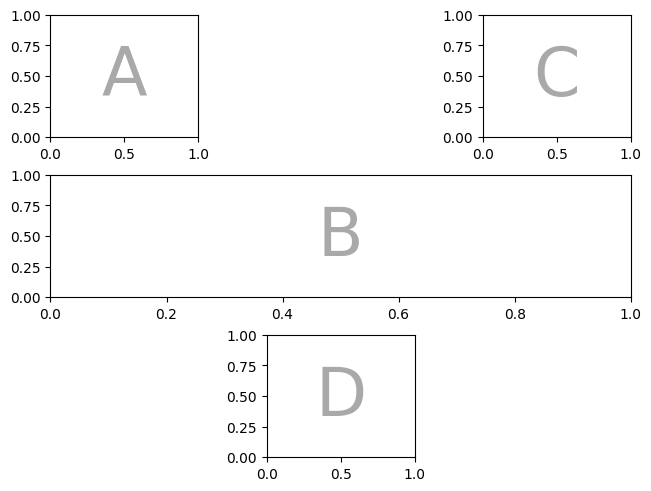

In [13]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    A.C
    BBB
    .D.
    """
)
identify_axes(axd)

If we prefer to use another character (rather than a period ``"."``)
to mark the empty space, we can use *empty_sentinel* to specify the
character to use.



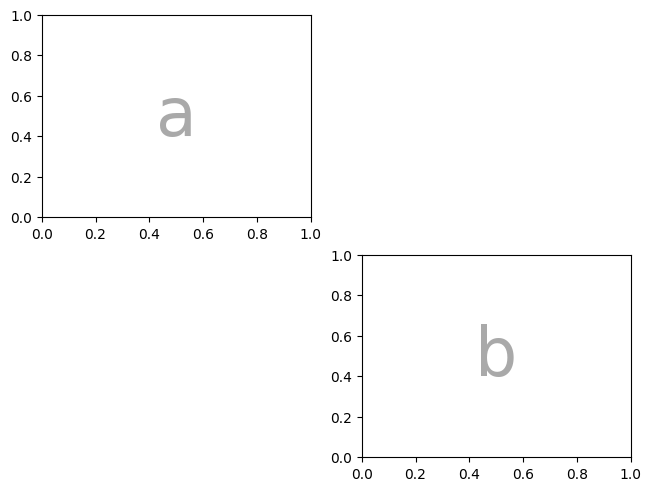

In [14]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    aX
    Xb
    """,
    empty_sentinel="X",
)
identify_axes(axd)

Internally there is no meaning attached to the letters we use, any
Unicode code point is valid!



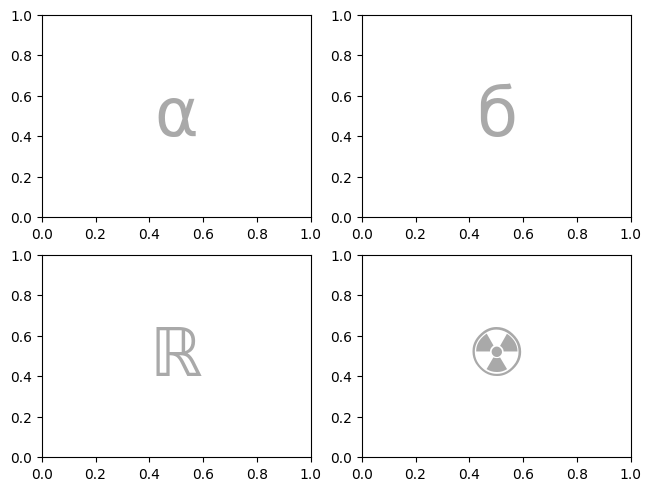

In [15]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """αб
       ℝ☢"""
)
identify_axes(axd)

It is not recommended to use white space as either a label or an
empty sentinel with the string shorthand because it may be stripped
while processing the input.

## Controlling mosaic and subplot creation

This feature is built on top of `.gridspec` and you can pass the
keyword arguments through to the underlying `.gridspec.GridSpec`
(the same as `.Figure.subplots`).

In this case we want to use the input to specify the arrangement,
but set the relative widths of the rows / columns via *gridspec_kw*.



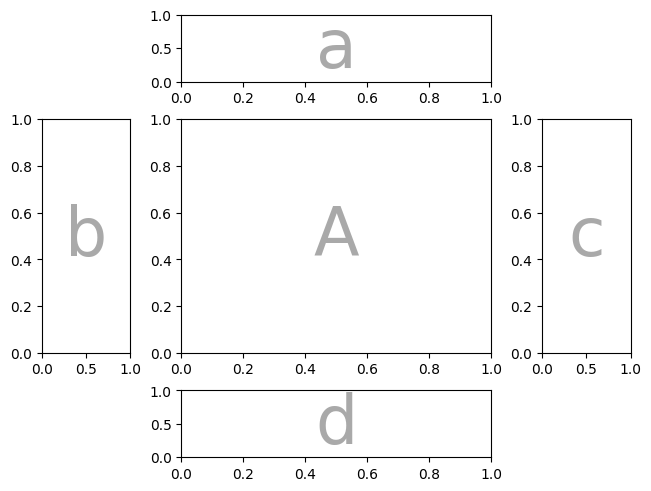

In [16]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    .a.
    bAc
    .d.
    """,
    # set the height ratios between the rows
    height_ratios=[1, 3.5, 1],
    # set the width ratios between the columns
    width_ratios=[1, 3.5, 1],
)
identify_axes(axd)

Or use the {*left*, *right*, *bottom*, *top*} keyword arguments to
position the overall mosaic to put multiple versions of the same
mosaic in a figure



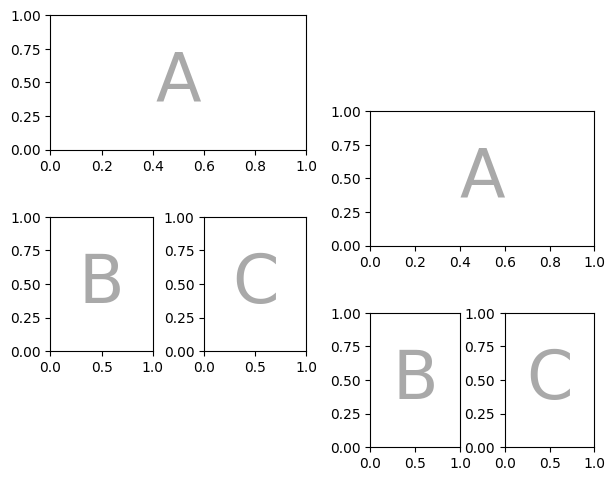

In [17]:
mosaic = """AA
            BC"""
fig = plt.figure()
axd = fig.subplot_mosaic(
    mosaic,
    gridspec_kw={
        "bottom": 0.25,
        "top": 0.95,
        "left": 0.1,
        "right": 0.5,
        "wspace": 0.5,
        "hspace": 0.5,
    },
)
identify_axes(axd)

axd = fig.subplot_mosaic(
    mosaic,
    gridspec_kw={
        "bottom": 0.05,
        "top": 0.75,
        "left": 0.6,
        "right": 0.95,
        "wspace": 0.5,
        "hspace": 0.5,
    },
)
identify_axes(axd)

Alternatively, you can use the sub-Figure functionality:



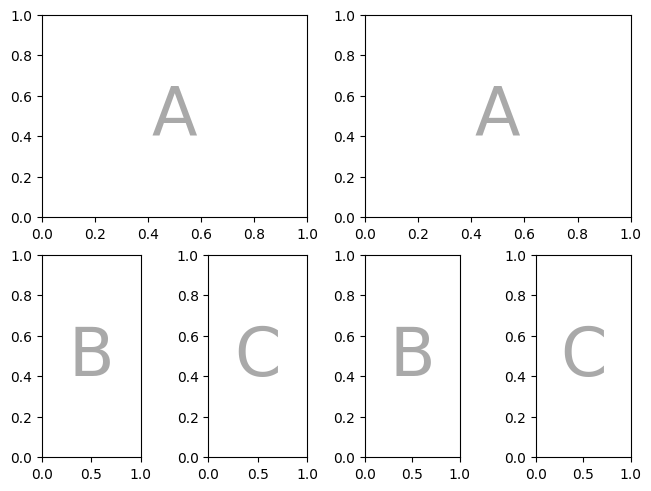

In [18]:
mosaic = """AA
            BC"""
fig = plt.figure(constrained_layout=True)
left, right = fig.subfigures(nrows=1, ncols=2)
axd = left.subplot_mosaic(mosaic)
identify_axes(axd)

axd = right.subplot_mosaic(mosaic)
identify_axes(axd)

We can also pass through arguments used to create the subplots
(again, the same as `.Figure.subplots`).



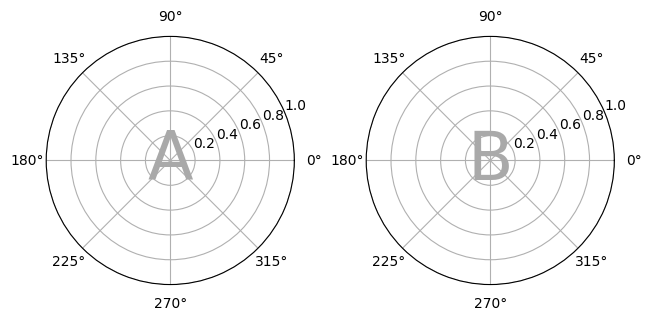

In [19]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    "AB", subplot_kw={"projection": "polar"}
)
identify_axes(axd)

## Nested List input

Everything we can do with the string short-hand we can also do when
passing in a list (internally we convert the string shorthand to a nested
list), for example using spans, blanks, and *gridspec_kw*:



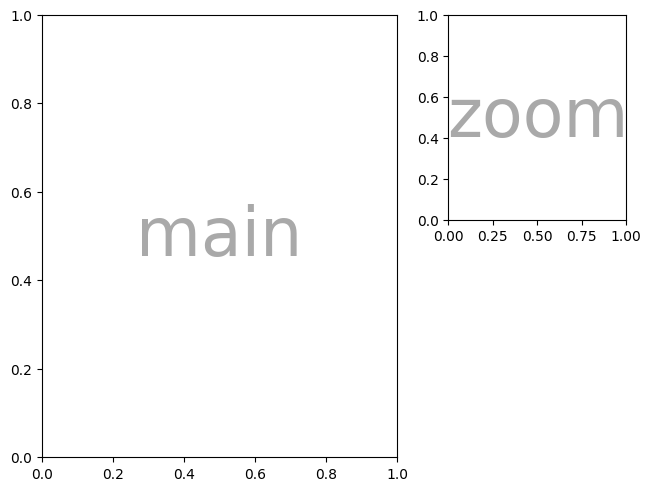

In [20]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    [
        ["main", "zoom"],
        ["main", "BLANK"],
    ],
    empty_sentinel="BLANK",
    width_ratios=[2, 1],
)
identify_axes(axd)

In addition, using the list input we can specify nested mosaics.  Any element
of the inner list can be another set of nested lists:



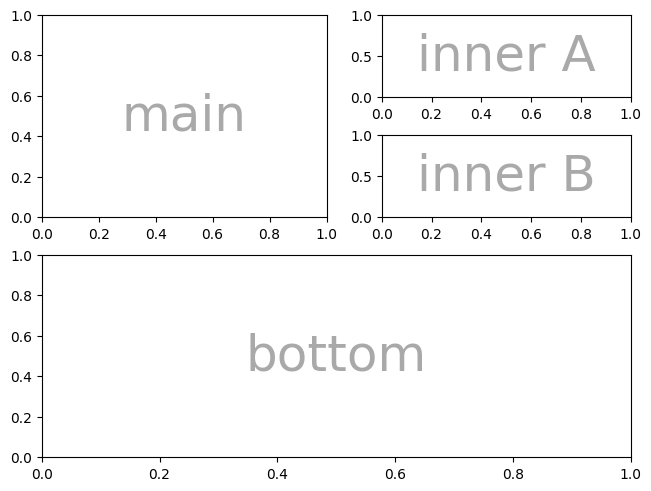

In [21]:
inner = [
    ["inner A"],
    ["inner B"],
]

outer_nested_mosaic = [
    ["main", inner],
    ["bottom", "bottom"],
]
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    outer_nested_mosaic, empty_sentinel=None
)
identify_axes(axd, fontsize=36)

We can also pass in a 2D NumPy array to do things like



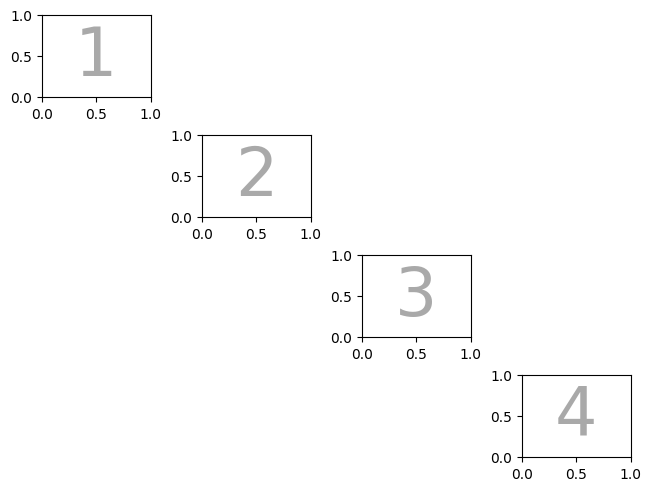

In [22]:
mosaic = np.zeros((4, 4), dtype=int)
for j in range(4):
    mosaic[j, j] = j + 1
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    mosaic,
    empty_sentinel=0,
)
identify_axes(axd)